# 基本分类：对服装图像进行分类


In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import gzip

In [4]:
print(tf.__version__)

2.1.0


In [33]:
import os
# 指定使用第一块gpu进行训练
os.environ['CUDA_VISIBLE_DEVICES']='0'


# 1-导入 Fashion MNIST 数据集

In [6]:
def ym_load_data(data_folder):
    '''
    ---定义加载数据的函数，data_folder为保存gz数据的文件夹，该文件夹下有4个文件
    ---p:data_folder：数据集路径
    '''

    files = [
      'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
    ]

    paths = []
    for fname in files:
        paths.append(os.path.join(data_folder,fname))

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

    return (x_train, y_train), (x_test, y_test)

In [7]:
(train_images, train_labels), (test_images, test_labels) = ym_load_data(r'E:\a_code_place\data\FashionMNIST')

每个图像都会被映射到一个标签。由于数据集不包括类名称，请将它们存储在下方，供稍后绘制图像时使用：

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2-浏览数据
在训练模型之前，我们先浏览一下数据集的格式。以下代码显示训练集中有 60,000 个图像，每个图像由 28 x 28 的像素表示：


In [9]:
train_images.shape

(60000, 28, 28)

# 3- 预处理数据
在训练网络之前，必须对数据进行预处理。如果您检查训练集中的第一个图像，您会看到像素值处于 0 到 255 之间：

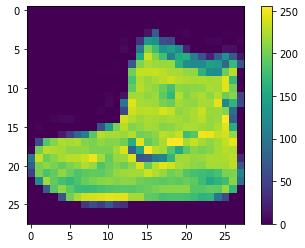

In [10]:
plt.figure()
#plt.imshow(train_images[0], plt.cm.gray)
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

将这些值缩小至 0 到 1 之间，然后将其馈送到神经网络模型。为此，请将这些值除以 255。请务必以相同的方式对训练集和测试集进行预处理：

In [11]:
train_images = train_images / 255.0
test_images = test_images / 250

为了验证数据的格式是否正确，以及您是否已准备好构建和训练网络，让我们显示训练集中的前 25 个图像，并在每个图像下方显示类名称。

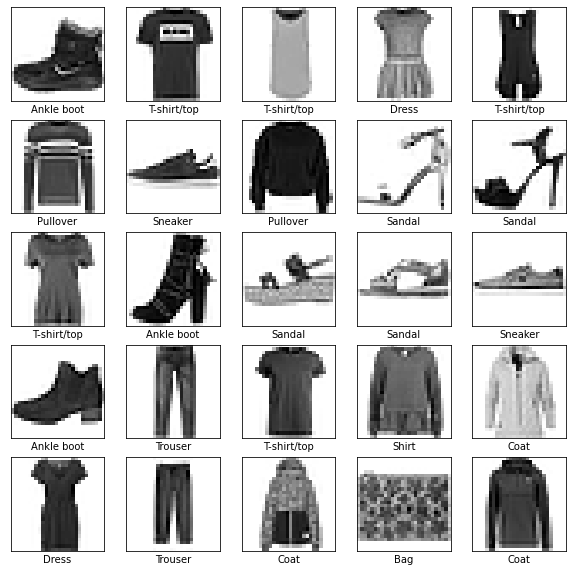

In [12]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# 3- 构建模型

构建神经网络需要先配置模型的层，然后再编译模型。

## 3.1-设置层
神经网络的基本组成部分是层。层会从向其馈送的数据中提取表示形式。希望这些表示形式有助于解决手头上的问题。    

大多数深度学习都包括将简单的层链接在一起。大多数层（如 tf.keras.layers.Dense）都具有在训练期间才会学习的参数。

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

该网络的第一层 tf.keras.layers.Flatten 将图像格式从二维数组（28 x 28 像素）转换成一维数组（28 x 28 = 784 像素）。将该层视为图像中未堆叠的像素行并将其排列起来。该层没有要学习的参数，它只会重新格式化数据。    

展平像素后，网络会包括两个 tf.keras.layers.Dense 层的序列。它们是密集连接或全连接神经层。第一个 Dense 层有 128 个节点（或神经元）。第二个（也是最后一个）层会返回一个长度为 10 的 logits 数组。每个节点都包含一个得分，用来表示当前图像属于 10 个类中的哪一类。

## 3-2编译模型
在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：     

损失函数 - 用于测量模型在训练期间的准确率。您会希望最小化此函数，以便将模型“引导”到正确的方向上。    
优化器 - 决定模型如何根据其看到的数据和自身的损失函数进行更新。    
指标 - 用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。    

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

# 4-训练模型
训练神经网络模型需要执行以下步骤：    

1。将训练数据馈送给模型。在本例中，训练数据位于 train_images 和 train_labels 数组中。    
2。模型学习将图像和标签关联起来。    
3。要求模型对测试集（在本例中为 test_images 数组）进行预测。     
4。验证预测是否与 test_labels 数组中的标签相匹配。     

## 4-1向模型馈送数据
要开始训练，请调用 model.fit 方法，这样命名是因为该方法会将模型与训练数据进行“拟合”：

In [15]:
history = model.fit(train_images, train_labels, epochs = 10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.5056 - accuracy: 0.8225
Epoch 2/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3779 - accuracy: 0.8630
Epoch 3/10
60000/60000 [==============================] - 6s 99us/sample - loss: 0.3385 - accuracy: 0.8764
Epoch 4/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.3127 - accuracy: 0.8858
Epoch 5/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.2942 - accuracy: 0.8921
Epoch 6/10
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2812 - accuracy: 0.8954
Epoch 7/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.2690 - accuracy: 0.9005s - loss: 0.2688 - accuracy: 0.90
Epoch 8/10
60000/60000 [==============================] - 6s 101us/sample - loss: 0.2577 - accuracy: 0.9039
Epoch 9/10
60000/60000 [==============================] - 6s 105us/sample - loss: 0.

In [16]:
history.history ##  loss and acc

{'loss': [0.5056040725866954,
  0.37793683331807454,
  0.33846829016009966,
  0.3127069141000509,
  0.2941882384836674,
  0.2811933709482352,
  0.26900934395988785,
  0.25771561766465506,
  0.2483733445862929,
  0.23917721664905547],
 'accuracy': [0.8225167,
  0.86296666,
  0.8764333,
  0.8858167,
  0.89213336,
  0.89536667,
  0.9004667,
  0.90393335,
  0.90706664,
  0.91001666]}

在模型训练期间，会显示损失和准确率指标。此模型在训练数据上的准确率达到了 0.91（或 91%）左右。

## 4-2评估准确率
接下来，比较模型在测试数据集上的表现：

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 1) #verbose:0 or 1. Verbosity mode. 0 = silent, 1 = progress bar.
print('\nTest accuracy:', test_acc)

10000/10000 [==============================] - 1s 96us/sample - loss: 0.3449 - accuracy: 0.8794

Test accuracy: 0.8794


结果表明，模型在测试数据集上的准确率略低于训练数据集。训练准确率和测试准确率之间的差距代表过拟合。过拟合是指机器学习模型在新的、以前未曾见过的输入上的表现不如在训练数据上的表现。过拟合的模型会“记住”训练数据集中的噪声和细节，从而对模型在新数据上的表现产生负面影响。

## 4-3进行预测

In [18]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [19]:
predictions = probability_model.predict(test_images)

In [20]:
predictions.shape

(10000, 10)

predictions是对测试数据集中10000幅图片十分类的可能性大小。      
在上例中，模型预测了测试集中每个图像的标签。我们来看看第一个预测结果：

In [21]:
predictions[0]

array([6.2999803e-08, 1.1976738e-07, 1.1710292e-07, 2.0990742e-11,
       3.8631865e-07, 1.0850240e-04, 2.4585303e-08, 4.5166849e-03,
       9.2481173e-07, 9.9537319e-01], dtype=float32)

预测结果是一个包含 10 个数字的数组。它们代表模型对 10 种不同服装中每种服装的“置信度”。您可以看到哪个标签的置信度值最大：

In [22]:
np.argmax(predictions[0])

9

因此，该模型非常确信这个图像是短靴，或 class_names[9]。通过检查测试标签发现这个分类是正确的：

In [23]:
test_labels[0]

9

与预测输出最大置信度结果相同。    
您可以将其绘制成图表，看看模型对于全部 10 个类的预测。

In [24]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            class_names[predicted_label],
            100*np.max(predictions_array),
            class_names[true_label]),
        color = color
    )
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

## 4-4验证预测结果
在模型经过训练后，您可以使用它对一些图像进行预测。    

我们来看看第 0 个图像、预测结果和预测数组。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）。

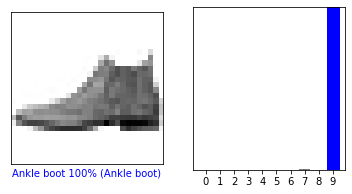

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

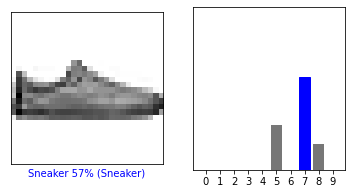

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

让我们用模型的预测绘制几张图像。请注意，即使置信度很高，模型也可能出错。

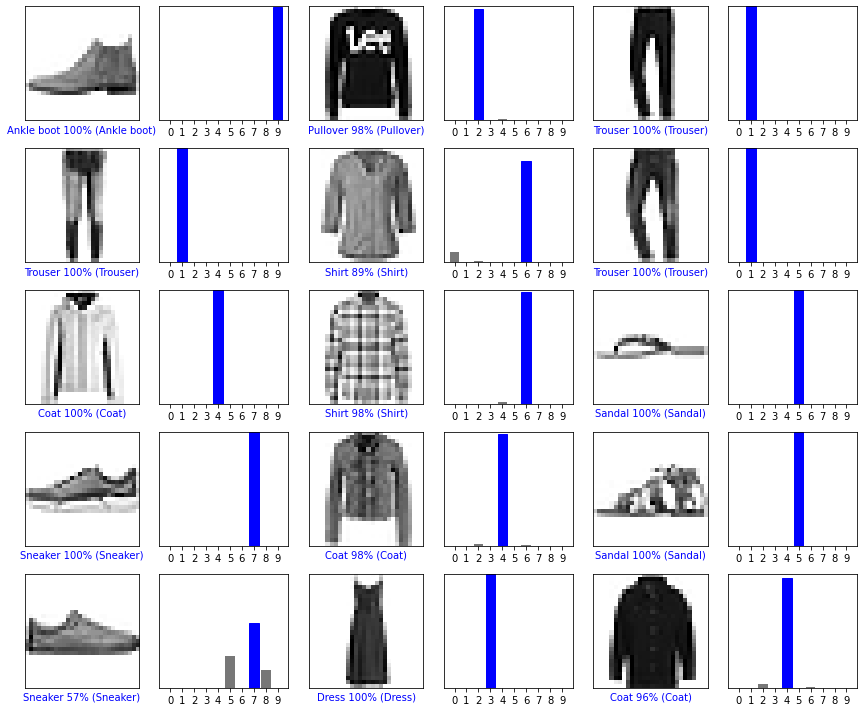

In [27]:
num_rows = 5
num_cols = 3
num_images = num_cols*num_rows
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# 5-使用训练好的模型
最后，使用训练好的模型对单个图像进行预测。

In [28]:
img = test_images[1]
img.shape

(28, 28)

tf.keras 模型经过了优化，可同时对一个批或一组样本进行预测。因此，即便您只使用一个图像，您也需要将其添加到列表中：

In [29]:
img = (np.expand_dims(img, 0))
img.shape

(1, 28, 28)

现在预测这个图像的正确标签：

In [30]:
predictions_single = probability_model.predict(img)
print(predictions_single)

[[5.8890855e-05 1.6751650e-13 9.7778535e-01 5.4372055e-08 1.6425254e-02
  2.4601302e-16 5.7304762e-03 7.2322982e-23 6.5071475e-08 8.7053574e-14]]


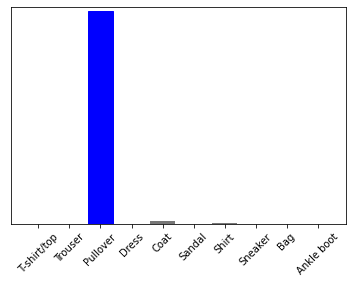

In [31]:
plot_value_array(1, predictions_single[0], test_labels)
plt.xticks(range(10), class_names, rotation = 45 )
plt.show()

keras.Model.predict 会返回一组列表，每个列表对应一批数据中的每个图像。在批次中获取对我们（唯一）图像的预测：

In [32]:
np.argmax(predictions_single[0])

2